In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/xiaotong/opt/anaconda3/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def hourly_return(x):
    return x.pct_change()

def max_drawdown(x):
    cum_max = x.cummax()
    md = (x - x.cummax())/x
    return md.cummin()    

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [3]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data.db'

In [4]:
# Parameters
from_date = "2021-12-06"
to_date = "2021-12-13"
token = "ETH"
connection_string = "sqlite:///data.db"


In [5]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])
prices.sort_values('ts',inplace=True)
prices.set_index('ts', inplace=True)
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-06 00:00:00,4167.68,4212.14,4153.06,4203.22,12167.745681,5.097211e+07,ETH,ETH
2021-12-06 01:00:00,4203.22,4209.58,4107.48,4136.87,10997.455780,4.554335e+07,ETH,ETH
2021-12-06 02:00:00,4136.82,4170.00,4106.00,4149.37,8918.725470,3.692097e+07,ETH,ETH
2021-12-06 03:00:00,4149.47,4172.97,4139.47,4154.71,8431.760889,3.504827e+07,ETH,ETH
2021-12-06 04:00:00,4155.69,4196.51,4152.44,4174.53,8235.892068,3.437900e+07,ETH,ETH


In [6]:
prices['returns'] = hourly_return(prices.close)
prices['drawdown'] = max_drawdown(prices.close)
prices['volatility'] = vol_ohlc(prices)
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,returns,drawdown,volatility
ts,,,,,,,,,,,
2021-12-06 00:00:00,4167.68,4212.14,4153.06,4203.22,12167.745681,5.097211e+07,ETH,ETH,NaN,0.000000,NaN
2021-12-06 01:00:00,4203.22,4209.58,4107.48,4136.87,10997.455780,4.554335e+07,ETH,ETH,-0.015786,-0.016039,NaN
2021-12-06 02:00:00,4136.82,4170.00,4106.00,4149.37,8918.725470,3.692097e+07,ETH,ETH,0.003022,-0.016039,NaN
2021-12-06 03:00:00,4149.47,4172.97,4139.47,4154.71,8431.760889,3.504827e+07,ETH,ETH,0.001287,-0.016039,NaN
2021-12-06 04:00:00,4155.69,4196.51,4152.44,4174.53,8235.892068,3.437900e+07,ETH,ETH,0.004770,-0.016039,NaN


In [7]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [8]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

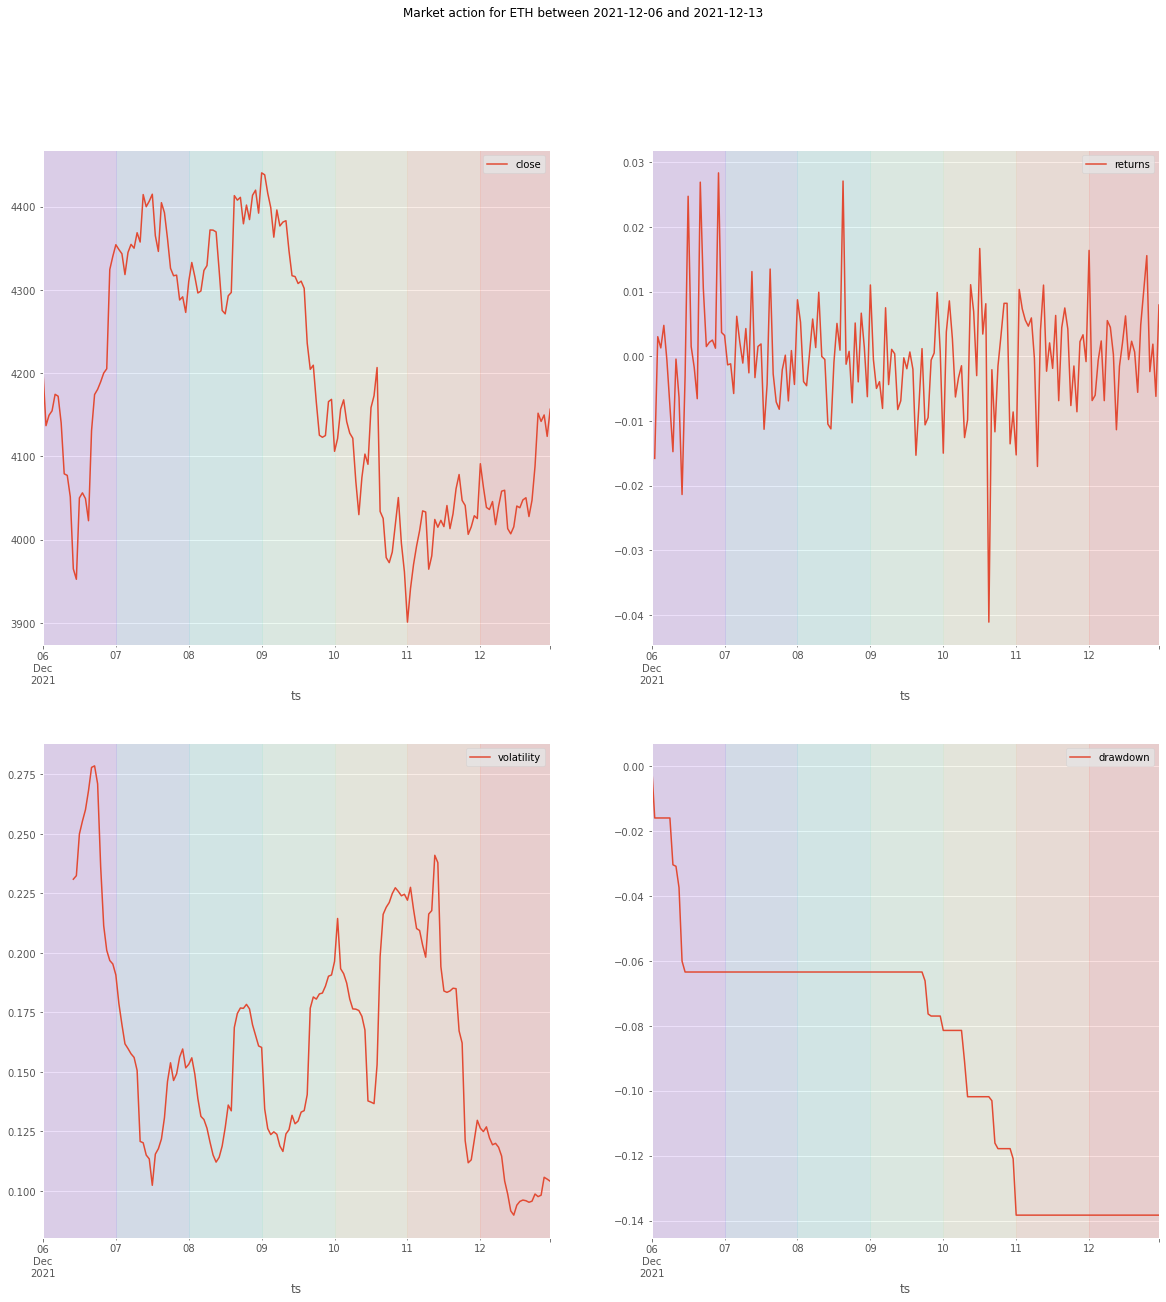

In [9]:
series_plot(prices[['close']], ax=ax[0, 0])
series_plot(prices[['returns']], ax=ax[0, 1])
series_plot(prices[['volatility']], ax=ax[1, 0])
series_plot(prices[['drawdown']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

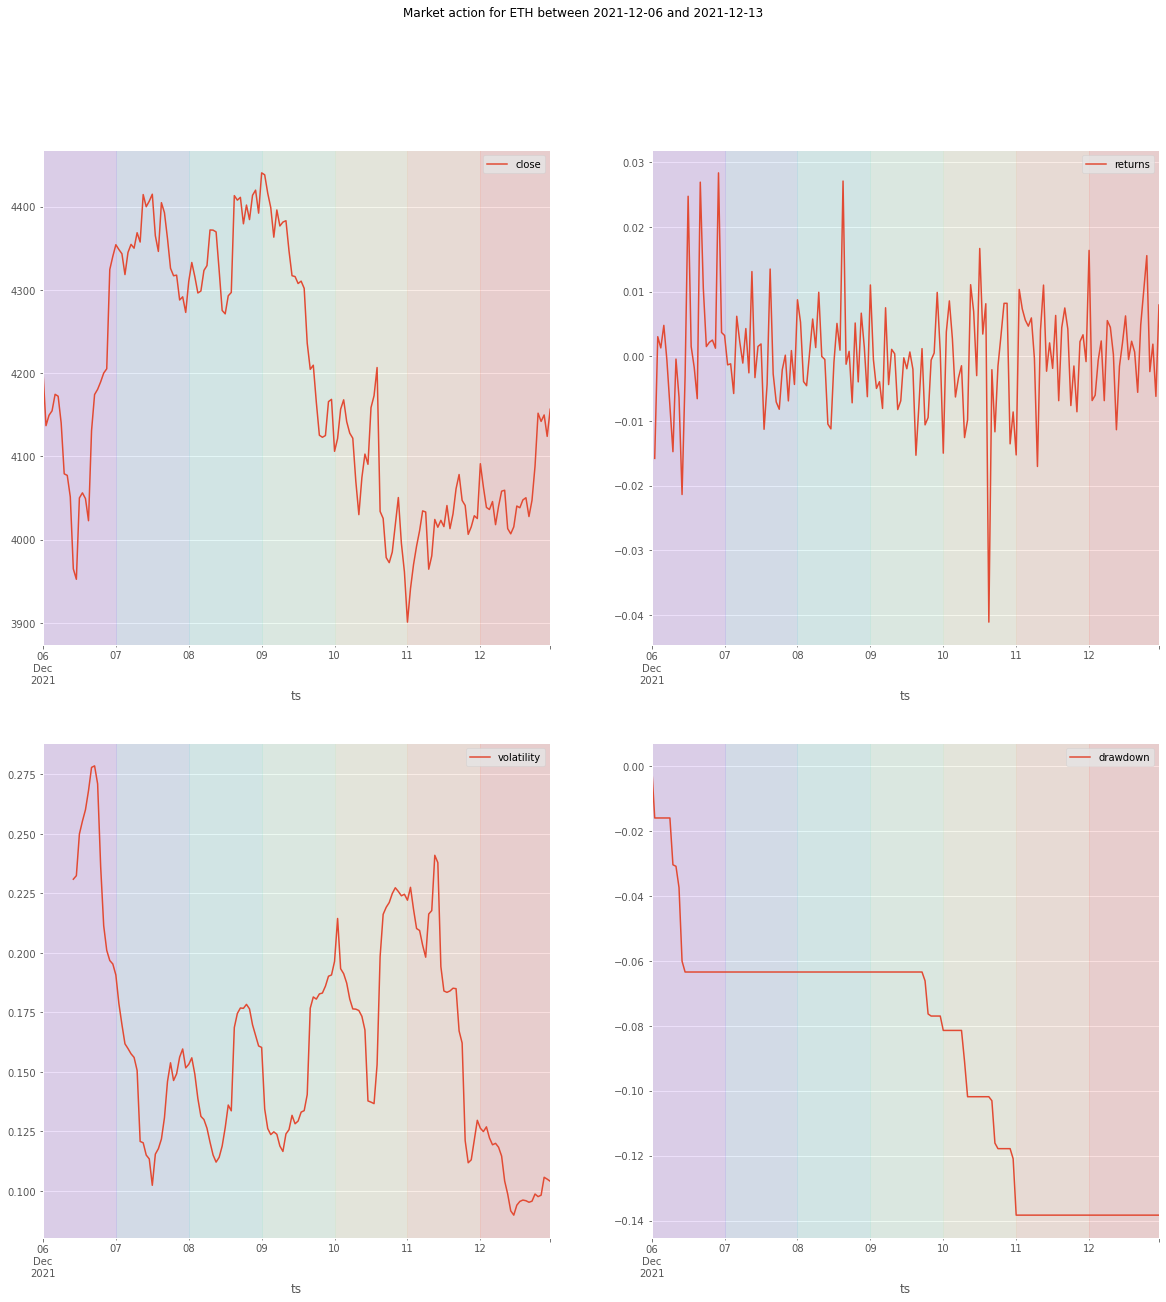

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)